# Apply drift correction to NorESM

In [1]:
import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr
#xr.set_options(enable_cftimeindex=True)

import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd

#import xcdat

import matplotlib as mpl
import matplotlib.pyplot as plt

#import cartopy.crs as ccrs
#from cartopy.util import add_cyclic_point

import glob


## notes on packages to add to this kernel
import nc_time_axis
import cartopy.crs as ccrs
import cartopy

import pickle

In [2]:
# load custom functions for analyzing flat10

from loading_function_flat10 import load_flat10, load_grid, select_time_slice, weighted_temporal_mean 

In [3]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

################
##### Dask #####
################

def get_ClusterClient(
        ncores=1,
        nmem='200GB',
        walltime='01:00:00',
        account='UWAS0155'):
    """
    Code from Daniel Kennedy
    More info about Dask on HPC - https://ncar.github.io/dask-tutorial/notebooks/05-dask-hpc.html
    """
    cluster = PBSCluster(
        cores=ncores,              # The number of cores you want
        memory=nmem,               # Amount of memory
        processes=ncores,          # How many processes
        queue='casper',            # Queue name
        resource_spec='select=1:ncpus=' +\
        str(ncores)+':mem='+nmem,  # Specify resources
        account=account,           # Input your project ID here
        walltime=walltime,         # Amount of wall time
        interface='ext',           # Interface to use
    )

    client = Client(cluster)
    return cluster, client

### Data location

Data downloaded for nird.sigma2.no to /glade/campaign/cgd/tss/people/aswann/flat10/

#### Models
Models with output:  
ACCESS-ESM1-5  
CESM2  
CNRM-ESM2-1  
GFDL-ESM4  
GISS_E2.1  
NorESM2-LM  
MPI-ESM1-2-LR 
CNRM-ESM2-1  
HadCM3LC-Bris  
UKESM1.2  

Directory structures within each model folder vary - need to account for this 

#### Experiments
flat10: 200 years at 10Pg/yr  
flat10_zec: branches from flat10 at 100 years, zero emissions for 200 years  
flat10_cdr: branches from flat10 at 100 years, ramps down to negative 10 Pg/yr over 100 years, continues at zero emissions for 100 years (until 200 years past flat10)

Total length of each simulation on its own: 200 years

#### Time indexing
Each model did it's time indexing in a different way. Need to account for all of the different calendars.

#### Missing files
The catalog of all CMIP files on glade is at:  
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.csv.gz'

GISS is missing the land fraction data (sftlf) and cell area data (areacella, areacello)
I tried to find matching grid files on NCAR, but none of the GISS models matched in resolution
Ended up downloading grid files from PCMDI

In [4]:
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

# modellist_orig= ['ACCESS-ESM1-5',  
#             'CESM2',    
#             'GFDL-ESM4',  
#             'GISS_E2.1',  
#             'NorESM2-LM',
#             'MPI-ESM1-2-LR',
#             'CNRM-ESM2-1',
#             'HadCM3LC-Bris',
#             'UKESM1.2']
# modellist=modellist_orig

runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

# varlist_load=['cVeg','cSoil','cLitter']#,'nbp','gpp','rh','tas','pr'] #, 'gpp','fgco2', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
# varlist_analyze=['cVeg','cSoil','cTot','cLitter']#,'nbp','gpp','rh','tas','pr']
# varlist=varlist_load
unitslist=['kgC m-2','kgC m-2','kgC m-2','kgC m-2 s-1','kgC m-2 s-1','kgC m-2 s-1','K','kg m-2 s-1']

# there seems to be a problem with ra for NorESM

modelcolors=['tab:blue','tab:orange','tab:green','tab:red','tab:gray','tab:purple','tab:cyan','gold','tab:brown']

troplat=30
highlat=60

In [5]:
##------ only for NorESM

modellist=['NorESM2-LM']
#modellist=['UKESM1.2']
runlist=['flat10_zec']
runlist_wc = ['*zec']
varlist=['cSoil']#'cVeg']#,'cSoil','cLitter']

In [6]:
#unitconversions
sperday=60*60*24
speryr=60*60*24*365

PgperKg = 1e-12
# to convert kg m-2 s-1 to kg/m2/yr multiply by speryr

In [7]:
# initialize a dictionary to hold all of the data
data_dict={}

### Start Dask workers

In [8]:
# ## Create Dask cluster and client, scale up to 20 workers
# cluster, client = get_ClusterClient(walltime='01:00:00')
# cluster.scale(20)
# client.wait_for_workers(20)

# ## Lists active workers and their status
# cluster.workers

### Load grid info

In [9]:
data_dict = load_grid(data_dict,modellist)

NorESM2-LM getting grid info


### Load data

In [10]:
data_dict=load_flat10(data_dict, modellist, runlist, runlist_wc, varlist)

loading model: NorESM2-LM
loading run: *zec
loading variable: cSoil
adding NorESM2-LM flat10_zec to dict


In [11]:
#modellist=modellist_orig
#varlist=varlist_analyze

# Calculate Metrics

### zonal average land sink

Zonal average land sink is calculated from total carbon on land averaged into latitude bands

In [12]:
# example for one model and one experiment
# needs a loop to be broadcast to all runs
#m=0
#e=0
#var='cTot'

#- initialize
C_global_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
C_highlat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
C_troplat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
C_midlat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])

# create a time series of years for the first dimension
ts= np.arange(350)

for m in range(len(modellist)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
    model=modellist[m]
    print('processing model: ' +model)

    # get area and land fraction
    ds_area = data_dict[modellist[m] +'_' +'areacella']
    ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']

    #----loop over experiments----# 
    for e in range(len(runlist)):
        run = runlist[e]
        print('processing run: ' +run)

        # get data from the dictionary
        ds=data_dict[modellist[m] +'_' +runlist[e]]

        # calculate land area
        # adjust the area grid for CESM
        if model=='CESM2':
            area = ds_area['areacella'].squeeze().reindex_like(ds, method='nearest',tolerance=0.05)
        else:
            area = ds_area['areacella'].reindex_like(ds, method='nearest',tolerance=0.05)
        
        landfrac=ds_landfrac['sftlf'].reindex_like(ds, method='nearest',tolerance=0.05)
        
        if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
            landfrac=landfrac/100
            
        landarea=area*landfrac
    
        
        #----loop over variables----#
        for v in range(len(varlist)):
            var=varlist[v]
            print('processing variable: ' +var)

            # load the drift correction
            if model=='NorESM2-LM':
                if var=='cVeg':
                    field = pickle.load(open('/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/NorESM2-LM_2D_TOTVEGC_ann_drift.pkl','rb'))
                    adj_matrix = xr.DataArray(np.squeeze(field), dims=['lat','lon'], coords={'latitude': ds.lat, 'longitude':ds.lon})##,unit={'g C m-2 yr-1'})
                    ty=ds['time'].dt.year
                    tyindx=ty-ty[0]+1
                    adjustment = adj_matrix* tyindx*(1/1000) #this is the drift for each time point and each gridcell in kg C m-2 yr-1

                    ds[var]=ds[var]+adjustment # remove the drift from the variable
                    
                elif var=='cSoil':
                    field = pickle.load(open('/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/NorESM2-LM_2D_TOTSOMC_ann_drift.pkl','rb'))
                    adj_matrix = xr.DataArray(np.squeeze(field), dims=['lat','lon'], coords={'latitude': ds.lat, 'longitude':ds.lon})##,unit={'g C m-2 yr-1'})
                    ty=ds['time'].dt.year
                    tyindx=ty-ty[0]+1
                    adjustment = adj_matrix* tyindx*(1/1000) #this is the drift for each time point and each gridcell in kg C m-2 yr-1

                    ds[var]=ds[var]+adjustment # remove the drift from the variable
                    
                elif var=='cLitter':
                    field = pickle.load(open('/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/NorESM2-LM_2D_TOTLITC_ann_drift.pkl','rb'))
                    adj_matrix = xr.DataArray(np.squeeze(field), dims=['lat','lon'], coords={'latitude': ds.lat, 'longitude':ds.lon})##,unit={'g C m-2 yr-1'})
                    ty=ds['time'].dt.year
                    tyindx=ty-ty[0]+1
                    adjustment = adj_matrix* tyindx*(1/1000) #this is the drift for each time point and each gridcell in kg C m-2 yr-1

                    ds[var]=ds[var]+adjustment # remove the drift from the variable

            
            data_var= weighted_temporal_mean(ds, var) # this is probably memory intesive?

            if var=='tas' or var=='pr': 
                # if this is *not* a carbon variable then we want to make an average
                C_global =(((data_var*landarea)).sum(dim=['lat','lon']))/landarea.sum(dim=['lat','lon'])
                C_highlat=(((data_var*landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon']))/((landarea.where(ds.lat>=highlat)).sum(dim=['lat','lon']))
                C_troplat=(((data_var*landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon']))/((landarea.where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon']))
                C_midlat=(((data_var*landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon']))/((landarea.where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon']))
    
                #put into matrix 
                C_global_mat[0:len(C_global),m,e,v]= C_global
                C_highlat_mat[0:len(C_global),m,e,v]= C_highlat
                C_troplat_mat[0:len(C_global),m,e,v]= C_troplat
                C_midlat_mat[0:len(C_global),m,e,v]= C_midlat
            
            else: # it is a carbon variable and we want to make a sum
                # total carbon on land. Becuase it is in units of carbon/area (kgC/m2), multiply by area
                # our area variable is in m2
                C_global =(((data_var*landarea)).sum(dim=['lat','lon']))
                C_highlat=((data_var*landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon'])
                C_troplat=((data_var*landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon'])
                C_midlat=((data_var*landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon'])
    
                #put into matrix and convert to PgC (kgC => PgC, divide by 10^12)
                C_global_mat[0:len(C_global),m,e,v]= C_global*PgperKg
                C_highlat_mat[0:len(C_global),m,e,v]= C_highlat*PgperKg
                C_troplat_mat[0:len(C_global),m,e,v]= C_troplat*PgperKg
                C_midlat_mat[0:len(C_global),m,e,v]= C_midlat*PgperKg

            # reset values after the end of the time series to nan
            C_global_mat[(len(C_global)):,m,e,v]=np.nan
            C_highlat_mat[(len(C_highlat)):,m,e,v]=np.nan
            C_troplat_mat[(len(C_troplat)):,m,e,v]=np.nan
            C_midlat_mat[(len(C_midlat)):,m,e,v]=np.nan


## for per area variables need area weighting
#cTot_global = (((ds[var]*landarea)).sum(dim=['lat','lon']))/(landarea.sum(dim=['lat','lon']))
#cTot_highlat=((ds[var]*landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon'])/(landarea.where(ds.lat>=highlat).sum(dim=['lat','lon']))
#cTot_troplat=((ds[var]*landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon'])/(landarea.where((ds.lat>=-troplat) & (ds.lat<=troplat)).sum(dim=['lat','lon']))
#cTot_midlat=((ds[var]*landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon'])/(landarea.where((ds.lat>=troplat) & (ds.lat<=highlat)).sum(dim=['lat','lon']))


 #----merge all variables into one dataset----#
# if it's the first variable, then start a new datset, otherwise merge with existing
#if v ==0:
#    ds_cTot_global = cTot_global.copy()
#else:
#    #dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])
#    ds_cTot_global = xr.merge([ds_cTot_global, cTot_global])

#dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])

processing model: NorESM2-LM
processing run: flat10_zec
processing variable: cSoil


In [13]:
ds_area

<xarray.Dataset> Size: 61kB
Dimensions:    (lat: 96, bnds: 2, lon: 144)
Coordinates:
  * lat        (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon        (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 2kB ...
    lon_bnds   (lon, bnds) float64 2kB ...
    areacella  (lat, lon) float32 55kB ...
Attributes: (12/48)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 1851-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     0.0
    ...                        ...
    title:                     NorESM2-LM output prepared for CMIP6
    tracking_id:               hdl:21.14100/488a9e29-0254-4e7e-8370-b8bf36f4ecd8
    variable_id:               areacella
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.6.0

In [14]:
# put the matrix into an xarray dataset
latlist=['global','highlat','troplat','midlat']

data_array_combined = np.full((len(ts), len(modellist), len(runlist), len(varlist), len(latlist)),np.nan)

data_array_combined[:,:,:,:,0]=C_global_mat
data_array_combined[:,:,:,:,1]=C_highlat_mat
data_array_combined[:,:,:,:,2]=C_troplat_mat
data_array_combined[:,:,:,:,3]=C_midlat_mat

In [15]:
np.shape(data_array_combined)

(350, 1, 1, 1, 4)

In [16]:
data_var

<xarray.DataArray (time: 210, lat: 96, lon: 144)> Size: 23MB
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lat        (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon        (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
    latitude   (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
    longitude  (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * time       (time) object 2kB 1960-01-01 00:00:00 ... 2169-01-01 00:00:00

In [17]:
arg=C_global_mat[:,m,e,v]

arg

array([2594.02823533, 2594.30840969, 2594.66962929, 2595.0768117 ,
       2595.42386547, 2595.63120422, 2595.96581903, 2596.32702635,
       2596.64354979, 2597.01070049, 2597.41814648, 2597.58495297,
       2597.77375294, 2598.05646409, 2598.34586843, 2598.53413294,
       2598.7558192 , 2599.04638179, 2599.49808722, 2599.88078389,
       2600.24068393, 2600.56576942, 2600.84303469, 2600.97692492,
       2601.20550881, 2601.4065606 , 2601.56005651, 2601.84195419,
       2602.10594257, 2602.31979314, 2602.59707107, 2602.89134143,
       2603.17959583, 2603.37610315, 2603.50613403, 2603.80872598,
       2604.14075958, 2604.43014594, 2604.61392538, 2604.71763574,
       2604.85178626, 2604.86816459, 2604.99147485, 2605.16868137,
       2605.43240853, 2605.57387482, 2605.63305445, 2605.7696836 ,
       2605.88583917, 2606.0224038 , 2606.11572271, 2606.19472836,
       2606.34814252, 2606.58026512, 2606.79694416, 2606.99199924,
       2606.97106053, 2606.95098363, 2607.01081382, 2607.02791

In [18]:


ds_C_global= xr.Dataset(
    {
        "data": (["time", "model", "run", "var","latrange"], data_array_combined)
    },
    coords={
        "time": ts,
        "model": modellist,
        "run": runlist,
        "var": varlist,
        "latrange": latlist
    }
)

In [19]:
ds_C_global

<xarray.Dataset> Size: 14kB
Dimensions:   (time: 350, model: 1, run: 1, var: 1, latrange: 4)
Coordinates:
  * time      (time) int64 3kB 0 1 2 3 4 5 6 7 ... 343 344 345 346 347 348 349
  * model     (model) <U10 40B 'NorESM2-LM'
  * run       (run) <U10 40B 'flat10_zec'
  * var       (var) <U5 20B 'cSoil'
  * latrange  (latrange) <U7 112B 'global' 'highlat' 'troplat' 'midlat'
Data variables:
    data      (time, model, run, var, latrange) float64 11kB 2.594e+03 ... nan

In [20]:
# - save the matrix to a netcdf file

##ds_C_global.to_netcdf("C_metrics_matrix.nc")

<xarray.Dataset> Size: 6kB
Dimensions:   (time: 350)
Coordinates:
  * time      (time) int64 3kB 0 1 2 3 4 5 6 7 ... 343 344 345 346 347 348 349
    model     <U10 40B 'NorESM2-LM'
    run       <U10 40B 'flat10_zec'
    var       <U5 20B 'cSoil'
    latrange  <U7 28B 'global'
Data variables:
    data      (time) float64 3kB 2.594e+03 2.594e+03 2.595e+03 ... nan nan nan


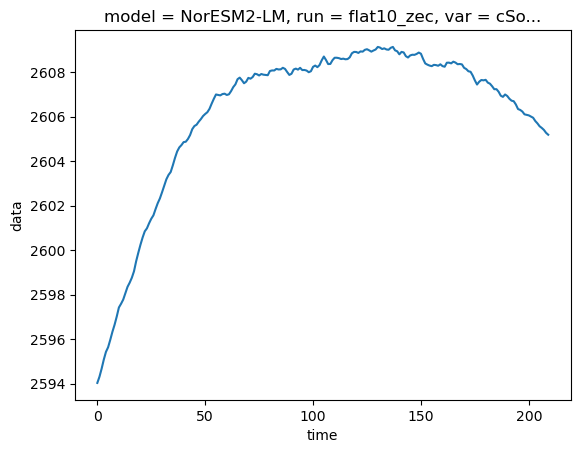

In [21]:
# to load data from this ds

# Access data for one model, run, var, latrange

subset = ds_C_global.sel(model=modellist[0], run=runlist[0], var=varlist[0], latrange='global')

print(subset)

subset.data.plot()

## Shut down dask

In [22]:
## Once done, shut down the cluster
# client.shutdown()

In [23]:
# # clean up
# !rm ./dask-worker.e*
# !rm ./dask-worker.o*

# #---------# Snippets below #-----------#

In [25]:
data_var.lat


<xarray.DataArray 'lat' (lat: 96)> Size: 768B
array([-90.      , -88.105263, -86.210526, -84.315789, -82.421053, -80.526316,
       -78.631579, -76.736842, -74.842105, -72.947368, -71.052632, -69.157895,
       -67.263158, -65.368421, -63.473684, -61.578947, -59.684211, -57.789474,
       -55.894737, -54.      , -52.105263, -50.210526, -48.315789, -46.421053,
       -44.526316, -42.631579, -40.736842, -38.842105, -36.947368, -35.052632,
       -33.157895, -31.263158, -29.368421, -27.473684, -25.578947, -23.684211,
       -21.789474, -19.894737, -18.      , -16.105263, -14.210526, -12.315789,
       -10.421053,  -8.526316,  -6.631579,  -4.736842,  -2.842105,  -0.947368,
         0.947368,   2.842105,   4.736842,   6.631579,   8.526316,  10.421053,
        12.315789,  14.210526,  16.105263,  18.      ,  19.894737,  21.789474,
        23.684211,  25.578947,  27.473684,  29.368421,  31.263158,  33.157895,
        35.052632,  36.947368,  38.842105,  40.736842,  42.631579,  44.526316,
        46.421053,  48.315789,  50.210526,  52.105263,  54.      ,  55.894737,
        57.789474,  59.684211,  61.578947,  63.473684,  65.368421,  67.263158,
        69.157895,  71.052632,  72.947368,  74.842105,  76.736842,  78.631579,
        80.526316,  82.421053,  84.315789,  86.210526,  88.105263,  90.      ])
Coordinates:
  * lat       (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
    latitude  (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
Attributes:
    bounds:         lat_bnds
    units:          degrees_north
    axis:           Y
    long_name:      Latitude
    standard_name:  latitude